In [210]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
np.random.seed(32)
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import pickle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import make_column_selector

In [107]:
with open("train.pkl", "rb") as f:
    X_train, y_train = pickle.load(f)

In [160]:
with open("test.pkl", "rb") as f:
    X_test, y_test = pickle.load(f)

In [108]:
X_train.head()
len(X_train)

49000

In [109]:
class SmokingImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.distribution_with_never = None
        self.distribution_without_never = None

    def fit(self, X, y=None):
        self.distribution_without_never = X.loc[~X['smoking_history'].isin(['No Info', 'never']), 'smoking_history'].value_counts(normalize=True)
        self.distribution_with_never = X.loc[~X['smoking_history'].isin(['No Info']), 'smoking_history'].value_counts(normalize=True)
        return self

    def transform(self, X):
        # TODO dodac opje do uzywania with never

        X.loc[(X['smoking_history'] == 'No Info'), 'smoking_history'] = np.random.choice(
            self.distribution_without_never.index, 
            size=len(X[(X['smoking_history'] == 'No Info')]), 
            p=self.distribution_without_never.values
            )
        return X
    
    def get_feature_names_out(self, input_features=None):
        return ['smoking_history']


In [140]:
class ClinicalNotesBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()
    
    def fit(self, X, y=None):
        X = X["remainder__clinical_notes"].astype(str)
        X = X.str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(x.split(',')))
        self.mlb.fit(X_cleaned)
        return self
    
    def transform(self, X):
        X = X["remainder__clinical_notes"].astype(str)
        X = X.str.lower().str.strip()
        X = ' ' + X
        X_cleaned = X.str.replace(r'\.', ',', regex=True).str.replace(r'\s+', '_', regex=True)
        X_cleaned = X_cleaned.apply(lambda x: set(x.split(',')))
        return self.mlb.transform(X_cleaned)
    
    def get_feature_names_out(self, input_features=None):
        return self.mlb.classes_

In [149]:
def clip_bmi(X):
    X = X.copy()
    X['bmi'] = np.clip(X['bmi'], None, 50)
    return X

In [227]:
def remove_high_corr_columns(X, threshold=0.9):
    X = X.copy() # Tworzymy kopię, żeby nie modyfikować oryginału
    X = pd.DataFrame(X)
    corr_matrix = X.corr().abs()
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold:
                to_drop.add(corr_matrix.columns[i])

    return X.drop(columns=to_drop, errors="ignore").to_numpy()

class HighCorrelationRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        self.column_names_before_removal = [f"feature_{i}" for i in range(X.shape[1])]
        return self  # Nic nie musimy robić w fit
    
    def transform(self, X):
        X = remove_high_corr_columns(X, self.threshold)
        self.column_names_before_removal = [f"feature_{i}" for i in range(X.shape[1])]
        return X
    
    def get_feature_names_out(self, input_features=None):
        return self.column_names_before_removal

In [ ]:
drop_cols = ['year', 'location']
race_cols = [col for col in X_train.columns if col.startswith('race')]
drop_cols.extend(race_cols)

bin_features = ['hypertension', 'heart_disease']
num_features = ['age', 'bmi', 'hbA1c_level', 'blood_glucose_level']
cat_features = ['gender'] # + smoking + notes

gender_encoder = OneHotEncoder(categories=[['Male', 'Female']], drop=None, handle_unknown='ignore')
smoking_encoder = OneHotEncoder(categories=[['never', 'ever', 'current', 'not current', 'former']], drop=None, handle_unknown='ignore')

smoking_imputer = SmokingImputer()

preprocessor = ColumnTransformer(
    transformers=[
        ('drop', 'drop', drop_cols),
        ('scaler', StandardScaler(), num_features),
        ('genderEncoder', gender_encoder, cat_features),
        ('smokingImputer', smoking_imputer, ['smoking_history']),
        #('smokingEncoder', smoking_encoder, ['smoking_history'])
    ],
    remainder='passthrough'
)
# TODO moze kiedys zrobic z tego jeden pipeline

steps = [('clip_bmi', FunctionTransformer(clip_bmi)),
         ('preprocessor', preprocessor)]
pipeline = Pipeline(steps = steps)
X_train_transformed = pipeline.fit_transform(X_train)

# print(X_train_transformed[:5, :]) 

columns = preprocessor.get_feature_names_out()
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=columns)
print(columns)

preprocessor2 = ColumnTransformer(
    transformers=[
        ('smokingEncoder', smoking_encoder, ['smokingImputer__smoking_history']),
        ('clinicalNotesBinarizer', ClinicalNotesBinarizer(), ['remainder__clinical_notes'])
    ],
    remainder='passthrough'
)

preprocessor3 = ColumnTransformer(
    transformers=[
        ('removeCorr', HighCorrelationRemover(), slice(0, None))
    ],
    remainder='passthrough'
)

pipeline2 = Pipeline(steps = [('preprocessor2', preprocessor2), ('preprocessor3', preprocessor3)])
X_train_transformed = pipeline2.fit_transform(X_train_transformed_df)
print(X_train_transformed[:5, :]) 
columns = preprocessor3.get_feature_names_out()
#print(columns)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=columns)


X_test_transformed = pipeline.transform(X_test)
columns = preprocessor.get_feature_names_out()
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=columns)
X_test_transformed = pipeline2.transform(X_test_transformed_df)
columns = preprocessor3.get_feature_names_out()
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=columns)


['scaler__age' 'scaler__bmi' 'scaler__hbA1c_level'
 'scaler__blood_glucose_level' 'genderEncoder__gender_Male'
 'genderEncoder__gender_Female' 'smokingImputer__smoking_history'
 'remainder__hypertension' 'remainder__heart_disease'
 'remainder__clinical_notes']
[[0.0 0.0 0.0 1.0 0.0 1 0 0 1 0 1 1 1 0 0 0 0 0 -1.5046162719441207
  -1.1492973795838535 0.25410474332526123 0.41847133475057363 0.0]
 [0.0 0.0 0.0 1.0 0.0 1 0 0 1 0 1 0 1 0 0 0 0 0 -0.6594133233661283
  -0.8154856845003542 -0.49593523546697077 0.05062294505772955 0.0]
 [0.0 0.0 0.0 0.0 1.0 1 0 0 0 0 1 1 1 0 1 0 0 0 -1.771522466231908
  -1.323189983534328 -1.433485208957261 0.5410874646481884 0.0]
 [0.0 0.0 1.0 0.0 0.0 1 0 0 0 0 1 1 1 0 0 0 0 0 -1.4156475405148585
  -0.6431456930851516 0.5353697353723481 -0.19460931473749984 0.0]
 [1.0 0.0 0.0 0.0 0.0 1 0 0 0 0 0 0 0 1 0 0 1 0 0.2747583566411266
  0.7930209020415325 0.9103897247684646 -1.4207706137136469 0.0]]
['removeCorr__feature_0' 'removeCorr__feature_1' 'removeCorr__feature

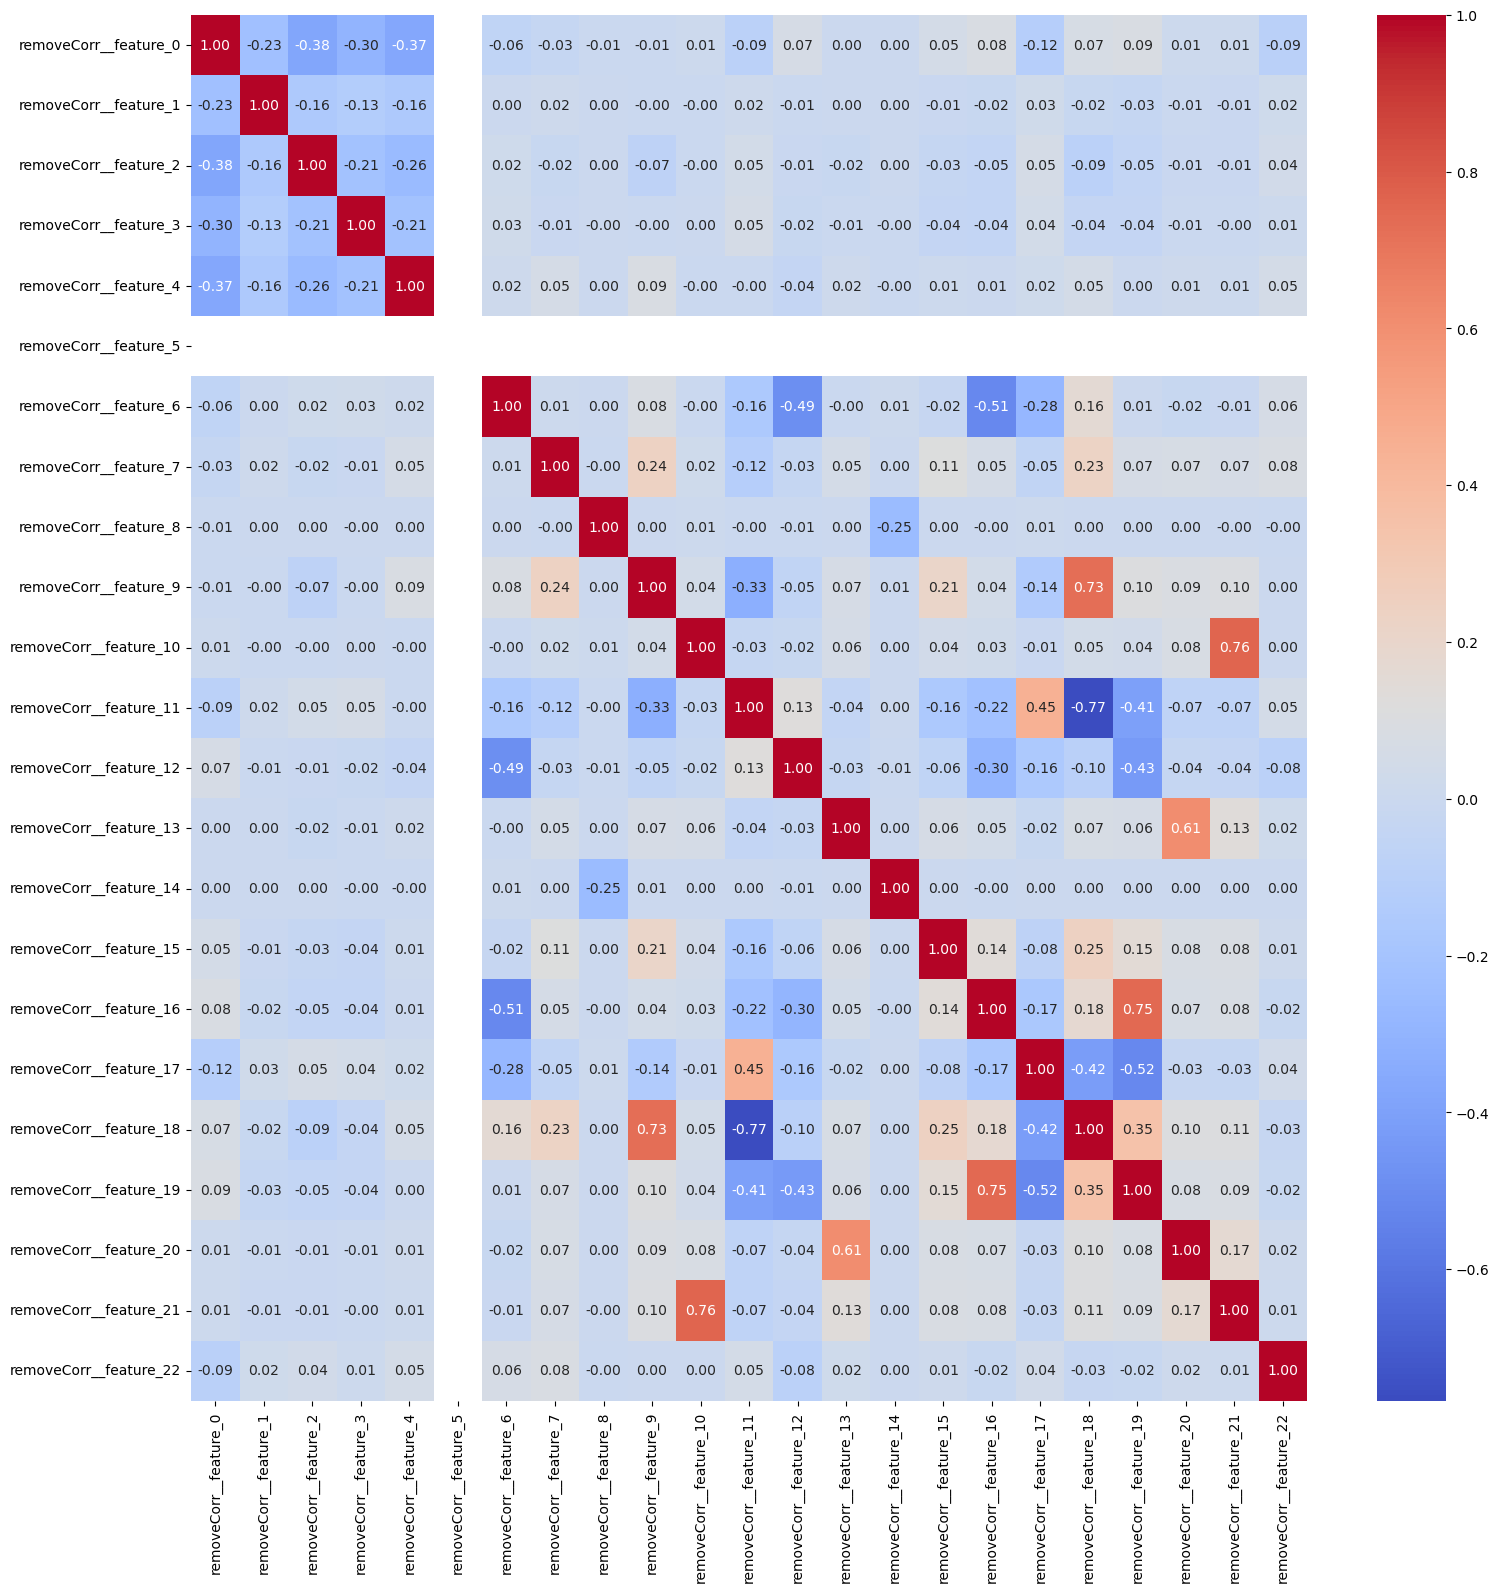

In [230]:
plt.figure(figsize=(18, 18))
sns.heatmap(X_train_transformed_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [178]:
sel = SelectKBest(f_classif, k=5)
X_train_sel = sel.fit_transform(X_train_transformed, y_train)
X_test_sel = sel.transform(X_test_transformed)

columns = preprocessor2.get_feature_names_out()
selected_columns = columns[sel.get_support()]

print("Selected features:", selected_columns)

Selected features: ['clinicalNotesBinarizer___high_hba1c_level'
 'clinicalNotesBinarizer___indicative_of_diabetes_or_poor_glucose_control'
 'remainder__scaler__age' 'remainder__scaler__hbA1c_level'
 'remainder__scaler__blood_glucose_level']
